In this notebook, I measure and plot the benchmark of $n_b$ for different combinations of angles $\theta_b$ and $\phi_b$ with the IBMQ. $n_b$ is defined as the number of qubits which give the right output after the bank preparing a state with an arbitrary rotation, then unrotating and measuring it. Math and physics discussion are kept to a minimum here. For a detailed explanation, please refer to section section III of 'Ensemble-Based Quantum-Token Protocol Benchmarked on IBM Quantum Processors' arXiv:2412.08530 (2024).

**Table of contents**<a id='toc0_'></a>    
- 1. [Protocol Execution](#toc1_)    
- 2. [Results](#toc2_)    
  - 2.1. [Angle Dependence](#toc2_1_)    
  - 2.2. [Distributions](#toc2_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import norm
plt.rcParams.update({'font.size': 12, "text.usetex": True, "font.family": "cmr"})

# Angle parametes
z = np.linspace(-1, 1, 9)
phi = np.linspace(0, 2*np.pi, 9)

# number of qubits
nq = 300

In [3]:
# qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import RGate
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.timing_constraints import TimingConstraints

service = QiskitRuntimeService(channel="ibm_quantum", token="") # token ommited

def nb_protocol(z, phi):
    """
    Protocol that the bank creates a token state by a rotation with angles theta_b and phi_b, then unrotates the token and measures it.

    Parameters:
    z (float): The arccos of the angle of the RGate
    phi (float): The phase of the RGate

    Returns:
    QuantumCircuit: The bank protocol to benchmark nb
    """
    theta = np.arccos(z)

    protocol = QuantumCircuit(QuantumRegister(1), ClassicalRegister(1))

    protocol.reset(0) # Bank initializes a qubit of the token
    protocol.append(RGate(theta, phi), [0]) # Bank prepares a qubit token state
    protocol.barrier()
    protocol.append(RGate(-theta, phi), [0]) # Bank unrotates the qubit
    protocol.measure(0, 0) # Bank Measures the qubit

    return protocol

def optmized_transpilation(backend, protocol, timing_constraints):
    """
    Transpile the protocol to the backend with the given timing constraints with optimal parameters previously tested
    
    Parameters:
    backend (IBMQBackend): The backend to transpile the protocol
    protocol (QuantumCircuit): The quantum circuit to transpile
    timing_constraints (TimingConstraints): The timing constraints of the backend

    Returns:
    QuantumCircuit: The transpiled quantum circuit
    """
    pass_manager = generate_preset_pass_manager(optimization_level=0, # Optimization with inverse cancelation but no commutative cancellation
                                                backend=backend, # Use the backend to transpile
                                                layout_method='dense', # Take the qubit with longer T2 and smallest gate time
                                                routing_method='none', # As only one qubit is used, we don't need routing
                                                translation_method="translator", # Use the synthesis method to map the gates to the native operations of the backend, translator method can also be used but results in longer pulses
                                                approximation_degree=1, # No approximation of the gates
                                                timing_constraints=timing_constraints, # Use the timing constraints of the backend
                                            )
    return pass_manager.run(protocol)

def get_counts0(jobs):
    """
    Read the jobs and returns the counts at the |0> state.

    Parameters:
    jobs (list of Job): The list of jobs to calculate nq

    Returns:
    np.array: The counts at the |0> state
    """
    # Intialize empty arrays to store the mean and standard deviation of the results
    nb = np.empty(len(jobs), dtype=float)

    for itr in range(len(jobs)):

        counts = jobs[itr].result().get_counts() # Get the counts of the results
        nb[itr] = counts['0']

    return nb

# 1. <a id='toc1_'></a>[Protocol Execution](#toc0_)

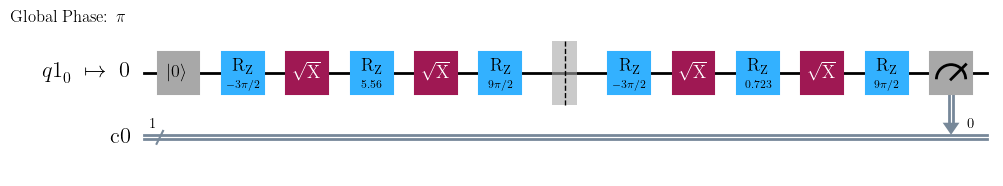

In [8]:
# Selects the backend, can either be osaka, brisbane or kyoto
backend = service.get_backend('ibm_brisbane')

# Get the time constrains of the backend for transpilation
backend_timing = backend.configuration().timing_constraints
timing_constraints = TimingConstraints(
                                        granularity=backend_timing['granularity'],
                                        min_length=backend_timing['min_length'],
                                        pulse_alignment=backend_timing['pulse_alignment'],
                                        acquire_alignment=backend_timing['acquire_alignment']
                                    )

itr_theta = 1
itr_phi = 8
transpiled_protocol = optmized_transpilation(backend, nb_protocol(z[itr_theta], phi[itr_phi]), timing_constraints)
# Runs on the backend the transpiled protocol
transpiled_protocol.draw('mpl', idle_wires=False)

In [ ]:
# Runs on the backend the transpiled protocol
backend.run(transpiled_protocol, shots=nq)

# 2. <a id='toc2_'></a>[Results](#toc0_)

The $n_b$ distributions are loaded and plotted. Sherbrooke and Kyiv show the highest bank self-acceptance values.

In [3]:
nb_osaka = np.loadtxt('./exp_data/osaka/nb.txt')
nb_brisbane = np.loadtxt('./exp_data/brisbane/nb.txt')
nb_kyoto = np.loadtxt('./exp_data/kyoto/nb.txt')
nb_kyiv = np.loadtxt('./exp_data/kyiv/nb.txt')
nb_sherbrooke = np.loadtxt('./exp_data/sherbrooke/nb.txt')

print("NORM FIT")
print(f"Sherbrooke: {norm.fit(nb_sherbrooke/nq)}")
print(f"Kyiv: {norm.fit(nb_kyiv/nq)}")
print(f"Osaka: {norm.fit(nb_osaka/nq)}")
print(f"Brisbane: {norm.fit(nb_brisbane/nq)}")
print(f"Kyoto: {norm.fit(nb_kyoto/nq)}")

NORM FIT
Sherbrooke: (np.float64(0.9893004115226337), np.float64(0.007639261259300585))
Kyiv: (np.float64(0.9922633744855968), np.float64(0.007422709389161557))
Osaka: (np.float64(0.9697119341563786), np.float64(0.0097457040004712))
Brisbane: (np.float64(0.8793004115226337), np.float64(0.034381527760322175))
Kyoto: (np.float64(0.7917695473251027), np.float64(0.031093850678242583))


## 2.1. <a id='toc2_1_'></a>[Angle Dependence](#toc0_)

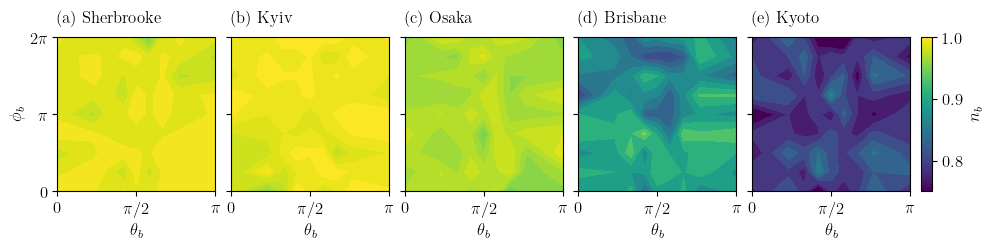

In [4]:
fig, axs = plt.subplots(1, 5, figsize=(11, 2), sharey=True, sharex=True)

axs[0].set_ylabel(r'$\phi_b$')

axs[0].contourf(np.arccos(z), phi, nb_sherbrooke.reshape(9, 9)/nq, cmap='viridis', vmin=0.75, vmax=1)
axs[1].contourf(np.arccos(z), phi, nb_kyiv.reshape(9, 9)/nq, cmap='viridis', vmin=0.75, vmax=1)
axs[2].contourf(np.arccos(z), phi, nb_osaka.reshape(9, 9)/nq, cmap='viridis', vmin=0.75, vmax=1)
axs[3].contourf(np.arccos(z), phi, nb_brisbane.reshape(9, 9)/nq, cmap='viridis', vmin=0.75, vmax=1)
axs[4].contourf(np.arccos(z), phi, nb_kyoto.reshape(9, 9)/nq, cmap='viridis', vmin=0.75, vmax=1)

for itr in range(5):
    axs[itr].set_xlabel(r'$\theta_b$')

axs[0].set_xticks([0, np.pi/2, np.pi], [r'$0$', r'$\pi/2$', r'$\pi$'])
axs[0].set_yticks([0, np.pi, 2*np.pi], [r'$0$', r'$\pi$', r'$2\pi$'])
axs[0].set_title('(a) Sherbrooke', fontsize=12, x=0, y=1.1, transform=axs[0].transAxes, ha='left')
axs[1].set_title('(b) Kyiv', fontsize=12, x=0, y=1.1, transform=axs[1].transAxes, ha='left')
axs[2].set_title('(c) Osaka', fontsize=12, x=0, y=1.1, transform=axs[2].transAxes, ha='left')
axs[3].set_title('(d) Brisbane', fontsize=12, x=0, y=1.1, transform=axs[3].transAxes, ha='left')
axs[4].set_title('(e) Kyoto', fontsize=12, x=0, y=1.1, transform=axs[4].transAxes, ha='left')

sm = cm.ScalarMappable(cmap='viridis')
sm.set_array([]) 
sm.set_clim(0.75, 1)

# Create the colorbar
cbar_ax = fig.add_axes([.91, 0.11, .01, .77])
cbar = fig.colorbar(sm, cax=cbar_ax, label=r'$n_b$', ticks=[.8, .9, 1])

fig.subplots_adjust(wspace=0.1)
fig.savefig('./figures/IBMQ_nb_angle.pdf', bbox_inches='tight', dpi=300, transparent=True)

## 2.2. <a id='toc2_2_'></a>[Distributions](#toc0_)

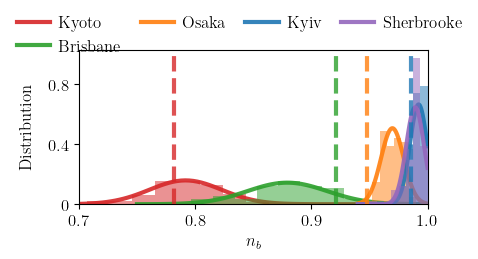

In [7]:
plt.figure(figsize=(4.5, 2))

plt.hist(nb_kyiv/nq, bins=7, alpha=.5, density=True, zorder=3)
plt.hist(nb_osaka/nq, bins=8, alpha=.5, density=True, zorder=2)
plt.hist(nb_brisbane/nq, bins=8, alpha=.5, density=True, zorder=1)
plt.hist(nb_kyoto/nq, bins=8, alpha=.5, density=True, zorder=0)
plt.hist(nb_sherbrooke/nq, bins=8, alpha=.5, density=True, zorder=4)

plt.plot(np.linspace(.65, 1, 100), norm.pdf(np.linspace(0.65, 1, 100), *norm.fit(nb_kyoto/nq)),  lw=3, color='C3', zorder=0, alpha=.9, label='Kyoto')
plt.plot(np.linspace(.75, 1, 100), norm.pdf(np.linspace(0.75, 1, 100), *norm.fit(nb_brisbane/nq)),  lw=3, color='C2', zorder=1, alpha=.9, label='Brisbane')
plt.plot(np.linspace(.94, 1, 100), norm.pdf(np.linspace(0.94, 1, 100), *norm.fit(nb_osaka/nq)),lw=3, color='C1', zorder=2, alpha=.9, label='Osaka')
plt.plot(np.linspace(.94, 1, 100), norm.pdf(np.linspace(0.94, 1, 100), *norm.fit(nb_kyiv/nq)), lw=3, color='C0', zorder=3, alpha=.9, label='Kyiv')
plt.plot(np.linspace(.94, 1, 100), norm.pdf(np.linspace(0.94, 1, 100), *norm.fit(nb_sherbrooke/nq)), lw=3, color='C4', zorder=4, alpha=.9, label='Sherbrooke')

plt.axvline(x=0.9859975714946958, linewidth=3, zorder=4, alpha=.8, linestyle='--', color='C0')
plt.axvline(x=0.9479971798617043, linewidth=3, zorder=4, alpha=.8, linestyle='--', color='C1')
plt.axvline(x=0.9216173182764851, linewidth=3, zorder=4, alpha=.8, linestyle='--', color='C2')
plt.axvline(x=0.7815467183413017, linewidth=3, zorder=4, alpha=.8, linestyle='--', color='C3')

plt.xlabel(r'$n_b$')
plt.ylabel('Distribution', labelpad=10)
plt.yticks([0, 81*.4, .8*81], ['0', '0.4', '0.8'])
plt.xlim(0.7, 1)
plt.legend(frameon=False, loc='center', bbox_to_anchor=(.46, 1.1), handletextpad=.5, ncols=4, columnspacing=1.2)

# plt.savefig('./figures/IBMQ_nb_hist.pdf', bbox_inches='tight', dpi=300, transparent=True)